<a href="https://colab.research.google.com/github/kra268/ChemCoder/blob/main/LR_Lipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
pip install PyTDC deepchem rdkit==2023.03.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import rdkit
rdkit.__version__

'2023.03.1'

In [3]:
import numpy as np
import pandas as pd
import deepchem as dc  # Featurization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tdc.single_pred import ADME
from rdkit.Chem import PandasTools, AllChem, Descriptors, AddHs

In [4]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
split = data.get_split()

Downloading...
100%|██████████| 298k/298k [00:00<00:00, 3.38MiB/s]
Loading...
Done!


In [5]:
split['train']

,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51
...,...,...,...
2935,CHEMBL1824376,O=C(Nc1cccc(O)c1)c1ccc(OCCCN2CCCC2)cc1OCc1ccccn1,1.78
2936,CHEMBL1081772,CC(=O)N(c1ccccc1)C1CC(C)N(S(=O)(=O)c2ccccc2)c2...,3.68
2937,CHEMBL199147,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
2938,CHEMBL15932,COc1cccc2[nH]ncc12,2.10


In [6]:
train = split['train']
test = split['test']
valid = split['valid']

In [7]:
train.shape

(2940, 3)

In [8]:
test.shape

(840, 3)

In [9]:
valid.shape

(420, 3)

In [10]:
PandasTools.AddMoleculeColumnToFrame(train, 'Drug', 'Molecule')

In [11]:
train.sample(3)

,Drug_ID,Drug,Y,Molecule
2587,CHEMBL528724,Cc1cc2nc(NC(=N)N)nc(C)c2cc1C,0.70,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1639770>
2170,CHEMBL2036732,O=C(Nc1ccc(N2CCOCC2)nc1)c1nnc(Nc2cccc(OCc3cccn...,3.30,<rdkit.Chem.rdchem.Mol object at 0x7f9bb162df50>
117,CHEMBL174107,CSc1ccc(N2C(N)=NC(N)=NC2(C)C)cc1,-0.84,<rdkit.Chem.rdchem.Mol object at 0x7f9bb15f1380>


In [12]:
PandasTools.AddMoleculeColumnToFrame(test, 'Drug', 'Molecule')
PandasTools.AddMoleculeColumnToFrame(valid, 'Drug', 'Molecule')

In [13]:
test.sample(3)

,Drug_ID,Drug,Y,Molecule
752,CHEMBL2094541,COc1cc(OC)nc(-n2ncc(Cl)c(Cl)c2=O)n1,1.40,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1663f40>
31,CHEMBL2086653,CC(C)(C)OC(=O)N1CCN(c2cnc(OCc3ccc(S(C)(=O)=O)c...,3.40,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1608190>
451,CHEMBL271703,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(N)cnc12,2.89,<rdkit.Chem.rdchem.Mol object at 0x7f9bb165ba70>


In [14]:
valid.sample(3)

,Drug_ID,Drug,Y,Molecule
359,CHEMBL2036577,CC(=O)N1CCN(c2ccc(NC(=O)c3nnc(Nc4ccccc4F)o3)cc...,2.51,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1670510>
140,CHEMBL2087848,CC#CCn1c(=O)c2c(-c3cncn3C)n(Cc3ccnc4ccc(Cl)cc3...,3.61,<rdkit.Chem.rdchem.Mol object at 0x7f9bb166a420>
89,CHEMBL2153174,O=S(=O)(Cc1c(F)cccc1F)N1CCN(c2ncccc2C(F)(F)F)CC1,3.90,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1668dd0>


In [15]:
train['Molecule'] = train.Molecule.apply(AddHs)

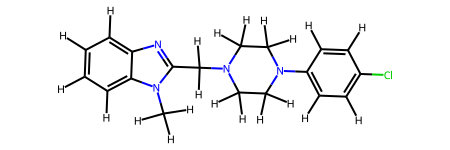

In [16]:
train.Molecule[0]

In [17]:
test['Molecule'] = test.Molecule.apply(AddHs)
valid['Molecule'] = valid.Molecule.apply(AddHs)

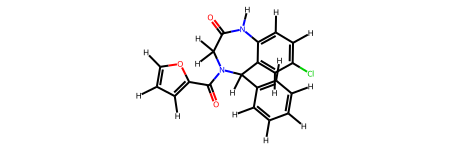

In [18]:
test.Molecule[0]

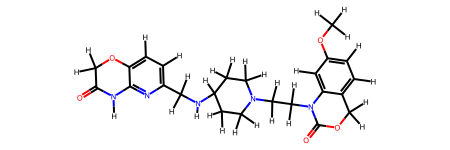

In [19]:
valid.Molecule[0]

In [22]:
des_keys = Descriptors.CalcMolDescriptors(valid.Molecule[0]).keys()

In [23]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [24]:
# Create a featurizer object
featurizer = dc.feat.RDKitDescriptors()

In [25]:
train['descript'] = train.Molecule.apply(featurizer.featurize)

In [26]:
train.head()

,Drug_ID,Drug,Y,Molecule,descript
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1672110>,"[[8.838871237455292, 8.838871237455292, 0.0083..."
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1672180>,"[[15.117957899646866, 15.117957899646866, 0.92..."
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69,<rdkit.Chem.rdchem.Mol object at 0x7f9bb16722d0>,"[[13.32122724552784, 13.32122724552784, 0.2505..."
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14,<rdkit.Chem.rdchem.Mol object at 0x7f9bb16720a0>,"[[8.889040858642577, 8.889040858642577, 0.4830..."
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51,<rdkit.Chem.rdchem.Mol object at 0x7f9bb16721f0>,"[[12.491907359623278, 12.491907359623278, 0.53..."


In [27]:
# Write for test and valid
test['descript'] = test.Molecule.apply(featurizer.featurize)
valid['descript'] = valid.Molecule.apply(featurizer.featurize)

In [28]:
train['descript'] = train['descript'].apply(lambda x: list(x[0]))

In [29]:
# Write for test and valid
test['descript'] = test['descript'].apply(lambda x: list(x[0]))
valid['descript'] = valid['descript'].apply(lambda x: list(x[0]))

In [30]:
test.sample(1)

,Drug_ID,Drug,Y,Molecule,descript
110,CHEMBL140453,CC(O)(C(=O)Nc1ccc(S(=O)(=O)c2ccc(O)cc2)cc1)C(F...,2.78,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1640270>,"[13.690915423800892, 13.690915423800892, 1.008..."


In [31]:
valid.sample(1)

,Drug_ID,Drug,Y,Molecule,descript
59,CHEMBL253741,COc1cc(Nc2cc(Nc3c(Cl)ccc4c3OCO4)ncn2)cc(OC)c1OC,3.07,<rdkit.Chem.rdchem.Mol object at 0x7f9bb1664c10>,"[8.70098030132835, 8.70098030132835, 0.0604891..."


In [32]:
# Write a function that separates out each descriptors into different columns
def get_des(data_set):
  for idx, mol in enumerate(data_set.Molecule):
    all_des = Descriptors.CalcMolDescriptors(mol)
    for des in des_keys:
      data_set.loc[idx,des] = all_des[des]

In [33]:
get_des(train)
get_des(test)
get_des(valid)

In [34]:
train.sample(1)

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1686,CHEMBL2181928,C[C@@H]1CN(c2ccc3c(n2)NC(=O)CO3)[C@H](c2ccccc2...,2.75,<rdkit.Chem.rdchem.Mol object at 0x7f9bb14ac9e0>,"[12.37563662420781, 12.37563662420781, 0.25164...",12.375637,12.375637,0.251647,-4.042691,0.918312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# A function to drop all the NULL values
# NOTE: RUN THIS ONLY ONCE! 
def drop_nulls(df):
    null_idxs = df[df.isnull().any(axis=1)].index.tolist()
    for idx in null_idxs:
        print('Dropping datapoints with NULL data')
        df = df.drop([idx])
        print(f'Index {idx} was dropped')

    return df

In [36]:
train = drop_nulls(train)
test = drop_nulls(test)
valid = drop_nulls(valid)

Dropping datapoints with NULL data
Index 1070 was dropped


In [37]:
train.shape

(2939, 214)

In [38]:
valid[valid.isnull().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [39]:
# Now let's set the target values for our data
y_train = train.Y
y_test = test.Y
y_valid = valid.Y

In [40]:
print(y_valid.shape)
print(valid.shape)

(420,)
(420, 214)


In [41]:
# Let's build our LinearRegression model! 

In [43]:
lr = LinearRegression(copy_X=True)

In [44]:
lr.fit(train['descript'].values.tolist(), y_train.values.tolist())

LinearRegression()

In [45]:
pred_test = lr.predict(test['descript'].values.tolist())

In [46]:
pred_test

array([ 2.59587920e+00,  2.19333184e+00,  1.71852720e+00,  1.44295204e+00,
        1.77989608e+00,  3.11013127e+00,  1.10875251e-01,  1.23470390e+00,
        1.81550384e+00,  2.23653186e+00,  1.88197904e+00,  7.20693709e-01,
        2.49866605e+00,  5.45851173e-01,  1.27173102e+00,  2.01084459e+00,
        1.22933883e+00,  2.83375597e+00,  2.95271045e+00,  2.17099679e+00,
        1.90127385e+00,  1.84581840e+00, -1.56897305e-01,  1.05840063e+00,
        1.16973561e+00,  2.35003345e+00,  3.20274396e+00, -6.52695876e-02,
        1.56675804e+00,  2.48028648e+00,  3.43066788e+00,  2.94907934e+00,
        2.38309121e+00,  3.29119480e+00,  1.87715733e+00,  2.52582085e+00,
        3.25030720e+00,  1.03133810e+00,  2.07940567e+00,  2.39610255e+00,
        7.18513745e-02,  3.04049671e+00,  2.11112094e+00,  4.83145015e+00,
        4.58165290e-01,  2.45464826e+00,  2.97809172e+00,  2.14964831e+00,
        2.94260132e+00,  2.96879208e+00,  2.55229604e+00,  2.73043852e+00,
        2.35262297e+00,  

In [47]:
import matplotlib.pyplot as plt

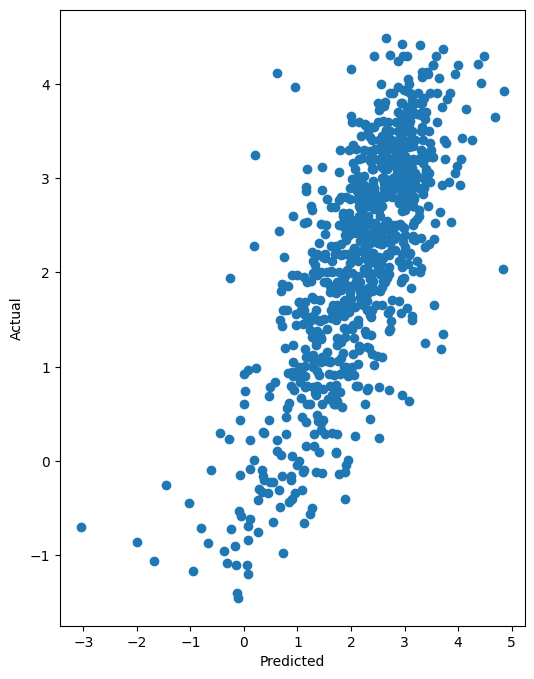

In [48]:
 plt.figure(figsize=(6,8))
 plt.scatter(pred_test, y_test)
 plt.xlabel('Predicted')
 plt.ylabel('Actual')
 plt.show()

In [49]:
mse = mean_squared_error(y_test, pred_test)

In [50]:
mse

0.6556795668886204

In [51]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, pred_test)
mae

0.636239071573667